### Deciphering and modelling the TGF-β signalling interplays specifying the dorsal-ventral axis of the sea urchin embryo

#### Swann Floc’hlay1, Maria Dolores Molina2#, Céline Hernandez1#, Emmanuel Haillot2, Morgane Thomas-Chollier1,3, Thierry Lepage2* and Denis Thieffry1*,


1. Institut de Biologie de l’ENS (IBENS), École normale supérieure, CNRS, INSERM, Université PSL, 75005 Paris, France.

2. Institut Biologie Valrose, Université Côte d’Azur, Nice, France.

3. Institut Universitaire de France (IUF), 75005 Paris, France.

\* Corresponding authors

emails: denis.thieffry@ens.psl.eu ; tlepage@unice.fr

\# These authors contributed equally to this work. 

The dorsal-ventral (D-V) axis specification in the sea urchin *Paracentrotus lividus* is controlled by various transcription factors, including two TGF-βs : Nodal and BMP2/4. However, the signalling network downstream of these key morphogens is not yet fully understood. To identify Nodal and BMP2/4 target genes, we have performed a systematic functional analysis using RNA sequencing and in situ hybridization screens. The analysis of these data enables to delineate various novel interactions.
To gain further insights into this developmental process, we have developed a logical model of the corresponding signalling/regulatory network, using the software GINsim (ginsim.org).
Our model analysis accounts for the specification of three main ectodermal regions along the D-V axis (ventral, ciliary and dorsal ectoderm) in terms of specific marker gene expression patterns.
In our model analysis, we first focused on the computation of stable states and on their reachability in single representative cells, depending on signalling inputs. These model simulations correctly reproduce wild-type and mutant phenotypes.
Next, taking advantage of the software EpiLog (epilog-tool.org), we have simulated grids of cells connected through diffusion of signalling molecules reproducing various reported patterns, including double Nodal mRNA injections.
This notebook covers the different analyses performed using GINsim and other logical modelling and analysis software.

### Environment setup

The first thing to do is to import the necessary libraries to performing the analyses.


In [1]:
# Tools necessary to run and pertrurb the model
import ginsim 
import biolqm
import pypint
import maboss

# Tools necessary to format and plot results of simulations
from colomoto_jupyter import tabulate
from colomoto.temporal_logics import *
from itertools import combinations
from functools import reduce

# Regular Python packages
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
import re
import pprint
from collections import Counter

This notebook has been executed using the docker image `colomoto/colomoto-docker:2021-10-01`

### Logical model import and summary

Next, we load the model built using the software GINsim in .zginml format.
At this point, it is available in the local computer memory as [SeaUrchin_model_ginsim_revised.zginml](SeaUrchin_model_ginsim_revised.zginml).

The pint module allows us to have summary information about the model as the number of nodes, the number of states and possible transitions. The following code display the model and some summary statistics.

In [2]:
# Loading model in the variable lrg_ppt using pint module and show summary statitics
# lrg_ppt = pypint.load("SeaUrchin_model_ginsim_revised.zginml")
# info_lrg = lrg_ppt.summary()
# pd.DataFrame([['nb_states',info_lrg['nb_states']],['nb_automata',info_lrg['nb_automata']],['nb_transitions',info_lrg['nb_transitions']]], columns=['Item','Number'])

# Loading model in the variable lrg using ginsim and convert it to a biolqm compliant model.
lrg = ginsim.load("SeaUrchin_model_ginsim_revised_0.zginml")
lqm2 = ginsim.to_biolqm(lrg)

# Show model regulatory graph
ginsim.show(lrg)

**Figure 1** : Unicellular logical model of the dorso-ventral axis specification in the sea urchin *Paracentrotus Lividus*, built using GINsim (ginsim.org). Green and red arrows represent activation and repression respectively. Squared elements represent multilevel nodes that can reach more than two states. This model can reach three different stable states : the dorsal (green), the ventral (blue) and the ciliary (pink) territories corresponding to different set of activated elements. Inputs of the model specified before simulations are shown in yellow.

**A** - Input nodes

| Node | Converging value | Logical rule | Value ventral | Value ciliary | Value dorsal |
|------|------------------|--------------|---------------|---------------|--------------|
|Nodal_In | * |No function| 2 | 1 | 1 |
|Lefty_In| * |No function| 1 | 1 | 1 |
|Panda_In| * |No function| 0 | 0 | 0 |
|Admp1_In| * |No function| 1 | 1 | 1 |
|Bmp2_4_In| * |No function| 1 | 1 | 1 |
|Chordin_In| * |No function| 2 | 2 | 1 |
|Tolloid_In| * |No function| 1 | 1 | 1 |
|Wnt_In| * |No function| 0 | 0 | 0 |
|Admp2_Trans| * |No function| 0 | 0 | 0 |

**B** - Ventral nodes

| Node | Converging value | Logical rule | Initial state |
|------|------------------|--------------|---------------|
|Univin| * | !Smad1/4/5/8:2| 1 |
|Alk4_5_7|1|(Nodal:1 & !Lefty & Univin & !Panda) &#124; (Nodal:2 & Univin & !Panda)| 0 |
|Alk4_5_7|2|Nodal:3 & Univin| 0 |
|Smad_2_3_4|1|Alk4/5/7:1 & !Smad1/4/5/8| 0 |
|Smad_2_3_4|2|Alk4_5_7:2| 0 |
|Nodal|2|Smad2_3_4| 0 |
|Bmp2_4|1|Smad2_3_4:1| 0 |
|Bmp2_4|2|Smad2_3_4:2| 0 |
|Lefty|1|Smad2_3_4| 0 |
|Chordin|1|Smad2_3_4| 0 |
|Admp1|1|Smad2/3/4 & !Smad1/4/5/8| 0 |
|Goosecoid|1|Smad2_3_4| 0 |
|Repressor_R1|1|!Goosecoid| 0 |
|FoxA|1|(FoxA &#124; Brachyury) & !Repressor_R1| 0 |
|Brachyury|1|!Repressor_R1 &#124; FoxA| 0 |

**C** - Dorsal nodes

| Node | Converging value | Logical rule | Initial state |
|------|------------------|--------------|---------------|
|Alk1_2_3_6|1|((Bmp2/4:1 & Admp1 & !Chordin) &#124; (Bmp2/4:1 & Admp1 & Tolloid & !Chordin:2)) & !Bmp2/4:2| 0 |
|Alk1_2_3_6|1|((Admp2 & !Chordin) &#124; (Admp2 & Tolloid & !Chordin:2)) & !Bmp2/4:2| 0 |
|Alk1_2_3_6|2|Bmp2/4:2| 0 |
|Smad1_4_5_8|1|Alk1/2/3/6:2 & Smad2/3/4:2| 0 |
|Smad1_4_5_8|2|(Alk1/2/3/6:2 & !Smad2/3/4:2) &#124; (Alk1/2/3/6:1 & !Smad2/3/4)| 0 |
|Tbx2_3|1|Smad1/4/5/8:2| 0 |
|IrxA|1|Tbx2_3| 0 |
|Glypican5|1|Smad1_4_5_8:2| 0 |
|Frz|1|Wnt_In| 0 |
|Admp2|1|Frz &#124; Smad1_4_5_8:2| 0 |

**D** - Ciliary nodes

| Node | Converging value | Logical rule | Initial state |
|------|------------------|--------------|---------------|
|FGFA|1|!Smad2_3_4 & !Smad1_4_5_8:2| 0 |
|Onecut|1|!(IrxA &#124; Goosecoid &#124; Smad2_3_4)| 0 |


**Table 1** : Rules of the logical model used to define the behaviour of each node for each territory. Input nodes (A) do not have any related function as they are initially set to a given fixed value when performing simulations.


### Attractor identification with bioLQM

We can compute all the attractors of the model using either GINsim or bioLQM. 
Hereafter, we first use the biolqm compliant model version.
We can extract the total number of stable states. Fixed points can be visualised on the network, as illustrated for the last stable state below, which show a ventrally defined state.

In [3]:
# Compute the total number of stable states
fps = biolqm.fixpoints(lqm2)
print(len(fps), "fixpoints found")


654 fixpoints found


In [4]:
# Find the wild-type stable state

fps_pd = pd.DataFrame(fps)
fps_pd = fps_pd.iloc[:,0:9]
fps_pd['input_list'] = fps_pd['Nodal_In'].astype(str) + fps_pd['Lefty_In'].astype(str) + fps_pd['Panda'].astype(str) + fps_pd['Bmp2_4_In'].astype(str) + fps_pd['Chordin_In'].astype(str) + fps_pd['Tolloid_In'].astype(str) + fps_pd['Admp1_In'].astype(str) + fps_pd['Admp2_Trans'].astype(str) + fps_pd['Wnt_In'].astype(str)
#fps_pd[fps_pd["input_list"] == "Nod_Lef_Pan_Bmp_Cho_Tol_Admp1_Admp2_Wnt"].index.values
v_index = fps_pd[fps_pd["input_list"] == "210121100"].index.values
c_index = fps_pd[fps_pd["input_list"] == "110121000"].index.values
d_index = fps_pd[fps_pd["input_list"] == "110211000"].index.values

# Ventral stable state
ginsim.show(lrg, fps[v_index[0]])


In [5]:
# Ciliary stable state
ginsim.show(lrg, fps[c_index[0]])

In [6]:
# Dorsal stable state
ginsim.show(lrg, fps[d_index[0]])


**Figure 3** : Example of ventral (top), ciliary (middle) and dorsal (bottom) stable state reached with this model. Yellow and white nodes correspond to active and inactive element respectively. Blue and grey arrows correspond to active and inactive regulation respectively.

### Simulation of wild-type dorso-ventral patterning

In addition to computing all the attractors, we also want to apply initial state restriction for the inputs, corresponding to specific state of the three ectoderm territories. This way, we can simulate specific region of the ectorderm in wild type conditions.

The first step consists in creating functions to define the state restriction, apply it and compare the result with the expected territory pattern. Then, we use these functions to run simulation on the model, more specifically to extract the fixpoints information.

##### Function definition

The first part of the code defines functions to help apply intial state and perturbation to the model, and extract fixpoint information.

In [7]:
# Function 1 : dash_pattern (from Céline)
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"
def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)


# Function 2 : getPert (from Swann)
# Integrate perturbation information with initial state.
# As initial state do not allow initial state for a multilevel node at level 2, we define Nodal as a perturbation
def getPert(rest_list, nodal_list, pert_list) :
    new_rest = {}
    # Adapt the initial state of perturbed node (sets it to its perturbation level)
    for k in rest_list.keys() :
        if k not in pert_list.keys() :
            new_rest[k] = rest_list[k]
        elif k in pert_list.keys() :
            new_rest[k] = pert_list[k]
    new_pert = ""
    # Format the perturbation in the node%level style, add Nodal_In if its not alreay present
    for k in pert_list.keys() :
        new_pert += " " + k + "%" + str(pert_list[k])
    if "Nodal_In" not in pert_list.keys() :
        new_pert += " Nodal_In%" + str(nodal_list["Nodal_In"])
    if "Chordin_In" not in pert_list.keys() :
        new_pert += " Chordin_In%" + str(nodal_list["Chordin_In"])
    return(new_rest, new_pert)


# Function 3 : getFxp (from Swann)
# Format the resulting output from fixpoints search.
# In case of multiple possible fixpoints, we store them as new individual keys in a dictionnary. Order is random
def getFxp(fixpoints) :
    fxp_formated = {}
    for territory in fixpoints.keys() :
        if len(fixpoints[territory]) == 1 :
            fxp_formated[territory] = [fixpoints[territory][0]]
        elif len(fixpoints[territory]) == 0 :
            fxp_formated[territory] = []
        elif len(fixpoints[territory]) > 1 :
            fxp_formated[territory] = fixpoints[territory]
    return(fxp_formated)

# Function 4 : split_multiSS (from Swann)
# In case where we find more than one stable state in one of the territory, we create one instance of
# simulation result for each different stable state reached
def split_multiSS(fxp_res, pert_name) :
    num_ss_max = max(len(fxp_res[ter]) for ter in fxp_res.keys())
    out_dict = {}
    if num_ss_max > 1 :
        for step in range(0,num_ss_max) :
            out_dict[pert_name + '_ss' + str(step)] = {}
            for ter in fxp_res.keys() :
                if len(fxp_res[ter])-1 < step :
                    item = len(fxp_res[ter])-1
                elif len(fxp_res[ter])-1 >= step : 
                    item = step
                out_dict[pert_name + '_ss' + str(step)][ter] = fxp_res[ter][item]
    elif num_ss_max == 1 :
        out_dict[pert_name] = {}
        for ter in fxp_res.keys() :
            out_dict[pert_name][ter] = fxp_res[ter][0]
    return(out_dict)


##### Wild-type simulation

Now that we have our helper functions defined, we simulate the model in wild-type condition regarding the initial state and display the result obtained. We perform one simulation for each of the three presumtive territories independently, as they have different initial state requirements.

In [8]:
## Define the wild type initial state conditions for the inputs in the three territories
# Univin is also fixed at 1 to avoid simulating events where Univin level reaches 0
inputs_state = { "ventral" : {"Lefty_In":1, "Bmp2_4_In":1 , "Admp1_In" : 1, "Wnt_In" : 0, "Panda" : 0, "Tolloid_In" : 1, "Univin" : 1, 'Admp2_Trans' : 1} , 
                 "ciliary" : {"Lefty_In":1, "Bmp2_4_In":1 , "Admp1_In" : 1, "Wnt_In" : 0, "Panda" : 0, "Tolloid_In" : 1, "Univin" : 1, 'Admp2_Trans' : 1} ,
                 "dorsal" : {"Lefty_In":1, "Bmp2_4_In":1 , "Admp1_In" : 1, "Wnt_In" : 0, "Panda" : 0, "Tolloid_In" : 1, "Univin" : 1, 'Admp2_Trans' : 1}}
core_vals = {}

# Define the wild type initial state conditions for Nodal input in the three territories
nodal_state = {"ventral" : {"Nodal_In" : 2, "Chordin_In" : 2},
               "ciliary" : {"Nodal_In" : 1, "Chordin_In" : 2},
               "dorsal" : {"Nodal_In" : 1, "Chordin_In" : 1}}

# Merge dict for figure
import copy
fig_inputs = copy.deepcopy(inputs_state)
for mykey in fig_inputs.keys() :
    fig_inputs[mykey].update(nodal_state[mykey])
pd.DataFrame(fig_inputs)   


,ventral,ciliary,dorsal
Lefty_In,1,1,1
Bmp2_4_In,1,1,1
Admp1_In,1,1,1
Wnt_In,0,0,0
Panda,0,0,0
Tolloid_In,1,1,1
Univin,1,1,1
Admp2_Trans,1,1,1
Nodal_In,2,1,1
Chordin_In,2,2,1


**Table 2** : Activity levels of all the input nodes, defined for the simulation in wild type condition for each of the three ectoderm regions.

Finding 1 stable state(s) for ventral territory.
Finding 1 stable state(s) for ciliary territory.
Finding 1 stable state(s) for dorsal territory.


<Figure size 1080x432 with 0 Axes>

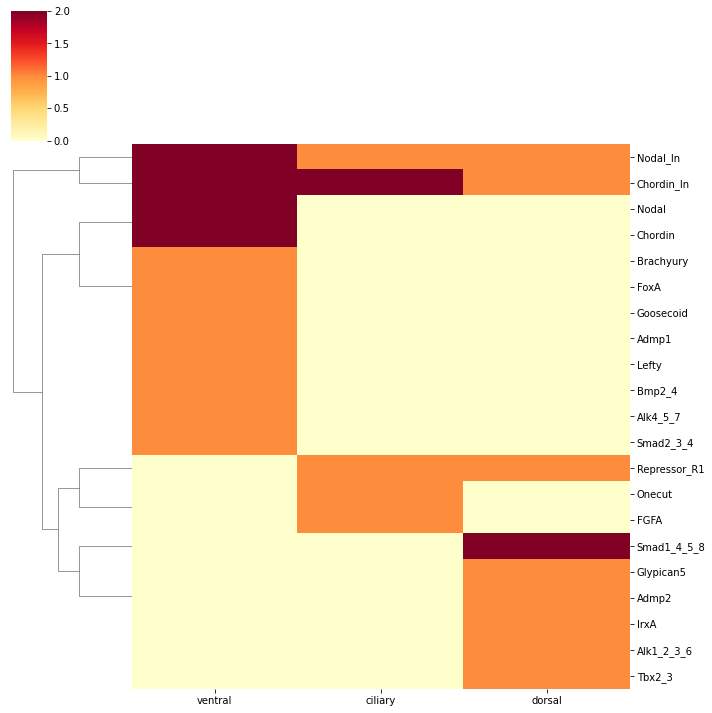

In [9]:
# Using the function and the initial state condition,
# we compute fixpoints of the model for the three wild type territories
fixpoints = {}
for territory in inputs_state.keys() :
    # Generate the pattern and perturbation to apply
    ter_rest, ter_pert = getPert(inputs_state[territory],  nodal_state[territory], {})
    pattern = dash_pattern(lqm2, {**ter_rest, **core_vals})
    # Apply pattern and perturbation to the model
    model_mod = biolqm.perturbation(biolqm.restrict(lqm2, pattern), ter_pert)
    # Compute fixpoints and store it in a dictionnary
    fixpoints[territory] = biolqm.fixpoints(model_mod)    
    print("Finding", len(fixpoints[territory]),"stable state(s) for", territory, 'territory.')

# We apply the function to our wild type simualtion and use it to plot the expression level of all nodes.
wild_type = getFxp(fixpoints)
wild_type = split_multiSS(wild_type, 'Wild_type')['Wild_type']
wt_fxp  = pd.DataFrame(wild_type)
plt.figure(figsize=(15, 6))
sns.clustermap(wt_fxp.dropna(0),  metric='euclidean', col_cluster=False, yticklabels=True, cmap='YlOrRd')

In [19]:
# We apply the function to our wild type simualtion and use it to plot the expression level of all nodes.
wild_type = getFxp(fixpoints)

wild_type = split_multiSS(wild_type, 'Wild_type')['Wild_type']
wt_fxp  = pd.DataFrame(wild_type)
wt_fxp

,ventral,ciliary,dorsal
Nodal_In,2,1,1
Chordin_In,2,2,1
Alk4_5_7,1,0,0
Smad2_3_4,1,0,0
Nodal,2,0,0
Bmp2_4,1,0,0
Lefty,1,0,0
Chordin,2,0,0
Admp1,1,0,0
Goosecoid,1,0,0


**Figure 4** : Heatmap of the stable states obtained for the wild-type simulation with the unicelluler logical model for each of the three ectodermal territories. Color scale corresponds to the state of each node (multilevel nodes can reach up to level 2). White region defines nodes which state do not impact the stable state of interest.

The computation of fixpoints in wild type conditions result in one fixpoint for each territory. According to the litterature, these fixpoints correspond to our expectation. Indeed according to the output being present, the Nodal cascade in expressed in the ventral region, the Bmp2_4 cascade is expressed in the dorsal region and the ciliary band desn't show any of them as they are both repressed in this last region.

In order to formalise this conclusion, we have built a function to compare a given fixpoint with the pattern obtained in the wild type based on the output nodes, consistent with the experimental results from *in-situ* expreiments. Note that we exclude Admp1 from the comparison, as this node is expressed in ventral but disapears in condition of overexpression of Nodal.

The code below translate the list of active and inactive nodes obtained from the simulations into the appropriate pattern definition. As an example, if the simulation gives as output only the nodes from the ventral region being active, then we considered that such event result in a ventrally defined ectoderm region.

<AxesSubplot:>

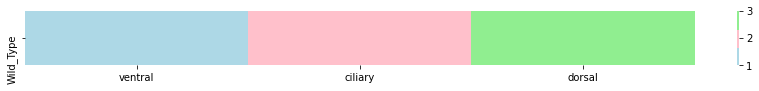

In [20]:
# We create a dictionnay to store the output nodes present in the wild type
# for each simulated territory condition
expected_output = {}
output_to_match = ['Bmp2_4','Brachyury','Chordin','FGFA','FoxA','Glypican5','Goosecoid','IrxA','Lefty','Nodal','Onecut','Repressor_R1','Smad6','Tbx2_3']

for T in wild_type.keys() :
    expected_output[T] = [n for n in wild_type[T].keys() if wild_type[T][n] > 0 and n in output_to_match]

# Function 3 : which_territory (from Swann)
# Based on a dictionnary with fixpoints for the three condition, it will compare these fixpoints
# with the one obtained in the wild type and define from which region this fixpoints belong.
def which_territory(name, state_dict, expected_dict, output_list):
    output_dict = {}
    for ter in state_dict.keys() :
        # Extract output nodes present
        checked_state = [n for n in state_dict[ter].keys() if state_dict[ter][n] > 0 and n in output_list]
        output_dict[ter] = 'unknown'
        # Compare with the wild type pattern (the list must be perfectly similar)
        for ns in expected_dict.keys() :
            if all(node in expected_dict[ns] for node in checked_state)  and all(node in checked_state for node in expected_dict[ns]) :
                output_dict[ter] = ns
    return({ name : output_dict})

# Apply the function to compare with wild type pattern
# Plot the fixpoints obtained in a color scheme along the dorsal-ventral axis.
# In all the figures, the color code is the following : ventral : blue, ciliary : pink, dorsal : green.
fig, (ax1) = plt.subplots(1,1, figsize=(15,1))
# Plot color scheme
wt_res = which_territory("Wild_Type" ,wild_type, expected_output, output_to_match)
wt_res = pd.DataFrame(wt_res)
wt_res = wt_res.replace({'Wild_Type' : { 'ventral' : 1, 'ciliary' : 2, 'dorsal' : 3 , 'unknown' : 0}}).transpose()
mycmap = mpl.colors.LinearSegmentedColormap.from_list("", ['lightblue',"pink","lightgreen"], N = 3)
sns.heatmap(wt_res.loc[:,['ventral','ciliary','dorsal']].apply(pd.to_numeric), cmap=mycmap, ax=ax1)


**Figure 5** : Result of the wild type simulations of the logical model along the dorso-ventral axis compared to the expected ectodermal territory patterns. Ventral, ciliary and dorsal territories are represented in blue, pink and green color respectively.

This code detects the specified pattern based on stable states values. We can use it on the list of total detected stable states, obtained from biolqm. This way, we can extract the number of stable states corresponding to each ectoderm territory.

In [21]:
# fps is the variable storing the result from bioloqm (see section Attractor identification with bioLQM)

# Load fps as dictionnary and compare stable states with wild-type pattern
dict_fps = { i : fps[i] for i in range(0, len(fps) ) }
wt_res = which_territory("Wild_Type" ,dict_fps, expected_output, output_to_match)

# Count the number of stable states mirroring each D-V pattern.
count_ss = Counter(wt_res['Wild_Type'].values())
print("Among the stable states obtained, we found :\n" + "\n".join("{!r} {!r} stable states".format(v, k) for k, v in count_ss.items()))

Among the stable states obtained, we found :
126 'ciliary' stable states
240 'dorsal' stable states
288 'ventral' stable states


### Perturbations analysis

Lepage's lab has performed a vast collection of perturbation experiments using morpholino and mRNA injection followed by *in-situ* hybridization. Based on this information, we aim to recapitulate the results observed in vivo by simulating perturbation experiments on our model and compute the fixpoints to test wether they are characteristic of one of the three territory patterns and wether they match the expected pertubation pattern observed in the *in-situ* experiments along the dorso-ventral axis.

We have used the same functions as for the wild type simulation for each set of conditions defining a given perturbation.

In [22]:
# Define all the pertubations to simluate by the list of perturbed node to which a fixed value is assigned.
input_perturbation = {'nodalE' : {"ventral" : {"Nodal_In" :3, "Bmp2_4_In" : 2},
                                  "ciliary" : {"Nodal_In" : 3, "Bmp2_4_In" : 2},
                                  "dorsal" : {"Nodal_In" : 3, "Bmp2_4_In" : 2, "Chordin_In" :2}},                      
                      'nodalKO' : {"ventral" : {"Nodal_In" : 0, "Lefty_In" : 0, "Bmp2_4_In" : 0},
                                   "ciliary" : {"Nodal_In" : 0, "Lefty_In" : 0, "Bmp2_4_In" : 0},
                                   "dorsal" : {"Nodal_In" : 0, "Lefty_In" : 0, "Bmp2_4_In" : 0}},
                      'leftyE' : {"ventral" : {"Nodal_In" : 0, "Bmp2_4_In" : 0, "Lefty_In" : 1},
                                  "ciliary" : {"Nodal_In" : 0, "Bmp2_4_In" : 0, "Lefty_In" : 1},
                                  "dorsal" : {"Nodal_In" : 0, "Bmp2_4_In" : 0, "Lefty_In" : 1}},
                      'leftyKO' : {"ventral" : {"Lefty_In" : 0, "Bmp2_4_In" : 0},
                                  "ciliary" : {"Lefty_In" : 0, "Bmp2_4_In" : 0},
                                  "dorsal" : {"Lefty_In" : 0, "Bmp2_4_In" : 0}},
                      'bmp24E' : {"ventral" : {"Bmp2_4_In" : 2},
                                  "ciliary" : {"Bmp2_4_In" : 2},
                                  "dorsal" : {"Bmp2_4_In" : 2}},
                      'bmp24KO' : {"ventral" : {"Bmp2_4_In" : 0},
                                  "ciliary" : {"Bmp2_4_In" : 0},
                                  "dorsal" : {"Bmp2_4_In" : 0}},
                      'bmp24_KO_panda_KO' : {"ventral" : {"Bmp2_4_In" : 0},
                                  "ciliary" : {"Bmp2_4_In" : 0, "Nodal_In" :2},
                                  "dorsal" : {"Bmp2_4_In" : 0, "Nodal_In" : 2}},
                      'chordinE' : {"ventral" : {"Chordin_In" : 2},
                                  "ciliary" : {"Chordin_In" : 2},
                                  "dorsal" : {"Chordin_In" : 2}},
                      'chordinKO' : {"ventral" : {"Chordin_In" : 0},
                                  "ciliary" : {"Chordin_In" : 0},
                                  "dorsal" : {"Chordin_In" : 0}}
                     }

pd.DataFrame(input_perturbation)



,nodalE,nodalKO,leftyE,leftyKO,bmp24E,bmp24KO,bmp24_KO_panda_KO,chordinE,chordinKO
ventral,"{'Nodal_In': 3, 'Bmp2_4_In': 2}","{'Nodal_In': 0, 'Lefty_In': 0, 'Bmp2_4_In': 0}","{'Nodal_In': 0, 'Bmp2_4_In': 0, 'Lefty_In': 1}","{'Lefty_In': 0, 'Bmp2_4_In': 0}",{'Bmp2_4_In': 2},{'Bmp2_4_In': 0},{'Bmp2_4_In': 0},{'Chordin_In': 2},{'Chordin_In': 0}
ciliary,"{'Nodal_In': 3, 'Bmp2_4_In': 2}","{'Nodal_In': 0, 'Lefty_In': 0, 'Bmp2_4_In': 0}","{'Nodal_In': 0, 'Bmp2_4_In': 0, 'Lefty_In': 1}","{'Lefty_In': 0, 'Bmp2_4_In': 0}",{'Bmp2_4_In': 2},{'Bmp2_4_In': 0},"{'Bmp2_4_In': 0, 'Nodal_In': 2}",{'Chordin_In': 2},{'Chordin_In': 0}
dorsal,"{'Nodal_In': 3, 'Bmp2_4_In': 2, 'Chordin_In': 2}","{'Nodal_In': 0, 'Lefty_In': 0, 'Bmp2_4_In': 0}","{'Nodal_In': 0, 'Bmp2_4_In': 0, 'Lefty_In': 1}","{'Lefty_In': 0, 'Bmp2_4_In': 0}",{'Bmp2_4_In': 2},{'Bmp2_4_In': 0},"{'Bmp2_4_In': 0, 'Nodal_In': 2}",{'Chordin_In': 2},{'Chordin_In': 0}


**Table 2** : List of the perturbation applied to the model in each region in order to resume the injection of mRNA and morpholinos in the KO and Gain-of-function experiments. Some pertubation involve more than one fixed state as some perturbation involve downstream elements through diffusion mecanisms, which cannot be directly defined inside an unicellular model. For example, an overexpression of Nodal lead to an overexpression of BMP2_4 which will be reported in the dorsal input node Bmp2_4_In.

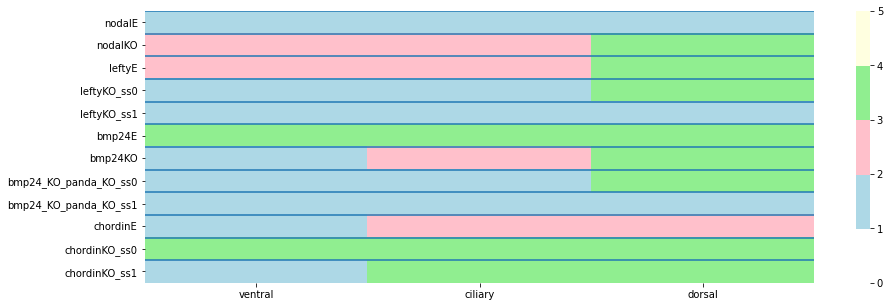

In [23]:
# For each perturbation, apply the perturbation to the model, compute the fixpoint and compare them to wild type.
all_pert = {}
all_fxp = {}
for pert in input_perturbation.keys() :
    pert_fxp = {}
    for territory in inputs_state.keys() :
        # Define and apply perturbation
        ter_rest, ter_pert = getPert(inputs_state[territory], nodal_state[territory], input_perturbation[pert][territory])
        pattern = dash_pattern(lqm2, {**ter_rest, **core_vals})
        model_mod = biolqm.perturbation(biolqm.restrict(lqm2, pattern), ter_pert)
        # Compute fixpoints
        pert_fxp[territory] = biolqm.fixpoints(model_mod)
    # Format and compare to wild type patterns
    pert_res = getFxp(pert_fxp)
    pert_res = split_multiSS(pert_res, pert)
    for single_pert in pert_res.keys() :
        all_fxp[single_pert] = pert_res[single_pert]
        single_pert_res = which_territory(single_pert , pert_res[single_pert], expected_output, output_to_match)
        all_pert = {**all_pert, **single_pert_res}

# Plot the result as a color code scheme and heatmap for individual nodes
# Reshape dictionnary for plotting as heatmap
levelfxp = pd.DataFrame.from_dict({(i,j): all_fxp[i][j] 
                           for i in all_fxp.keys() 
                           for j in all_fxp[i].keys()},
                       orient='index')

fig, (ax1) = plt.subplots(1,1, figsize=(15,5))
all_res = pd.DataFrame(all_pert).transpose()
all_res = all_res.applymap(lambda v: { 'ventral' : 1, 'ciliary' : 2, 'dorsal' : 3, 'unknown' : 4}.get(v,0))
mycmap = mpl.colors.LinearSegmentedColormap.from_list("", ['white','lightblue',"pink","lightgreen","lightyellow"], N = 5)
lalabel = [n for n in all_res.columns if re.match('ventral\w*',n)] + [n for n in all_res.columns if re.match('ciliary\w*',n)] + [n for n in all_res.columns if re.match('dorsal\w*',n)]
colgraph = sns.heatmap(all_res.loc[:,lalabel], cmap=mycmap, vmin=0, vmax=5, ax = ax1)
colgraph.hlines(range(0,len(all_res.index)), *colgraph.get_xlim())
plt.show()

**Figure 6** : Result of the perturbation simulations of the logical model along the dorso-ventral axis compared to the expected ectodermal territory patterns. Ventral, ciliary, dorsal and undefined territories are represented in blue, pink, green and yellow color respectively. The chordin_KO mutant has two different output, has its ventral region can reach two possible stable states (ventral and dorsal).

Comparing the simulation to the experimental result, we note that a large majority of the perturbations agree with the *in-situ* patterns. For example, the gain-of-function of Nodal results in a fully ventralised ectoderm as expected.

One discrepancy comes from the simulation of chordinKO mutant. Indeed, the simulation of the logical model predicts that two possible stable states can be reached in the presumptive ventral region, namely ventral and dorsal territories. According to the *in-situ* experiments, such mutant exclusively displays a weak dorsal pattern in the ventral region, arguing against the possibility to reach a ventral pattern.

### Stochastic analysis

To further explore this result, we use of the software MaBoss to perform stochastic simulation of the temporal behavior of the model using Markov chains. Such tool will help us overcome to limit of boolean modelling.

Indeed, the dorsal pattern observed is relatively weak and could be the result of the co-activation of both the ventral and dorsal cascades, each one partially inhibiting the other. As the logical formalism can only predict binary outputs, gradual and weak interactions mecanisms are part of the possible limitations of such modelling strategies, although the resulting groups of stable states predicted as reachable give us usefull insights about the potential ongoing regulatory cascades governing this precise territory specification.

The stochastic simulation will help us to compare how the two stable states are reached in the ventral region of the chordin KO mutant and assess wether one of them is favoured in term of temporal dynamic. In the following code, we simulate the temporal trajectory of the ventral territory in wild type and in chordin_KO conditions.


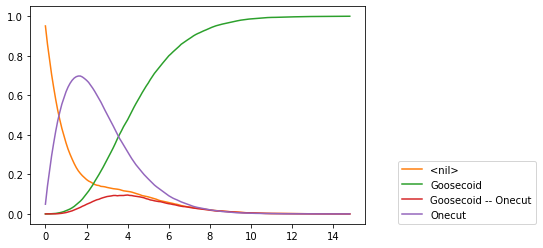

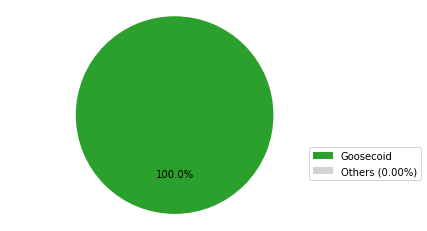

In [24]:
# Import the model in MaBoss compliant model and set simulation time step limit
master_simulation = ginsim.to_maboss(lrg)
master_simulation.update_parameters(time_tick=0.1, max_time=15)

# Set the node to be seen as output, for clarity, we select one output node from each of the three territory
# Goosecoid = Ventral ; Onecut = Ciliary ; IrxA = Dorsal
# Set the input node values for ventral initial state (note : mulitlevel node value are set for each individual level) and run model
maboss.set_output(master_simulation, ["Goosecoid", "Onecut", "IrxA"])
master_simulation_on = maboss.copy_and_mutate(master_simulation, ["Nodal_In_b1", "Nodal_In_b2","Lefty_In","Bmp2_4_In_b1","Admp1_In","Chordin_In_b1", "Chordin_In_b2", "Tolloid_In"], "ON")
master_simulation_off = maboss.copy_and_mutate(master_simulation_on, ["Bmp2_4_In_b2","Wnt_In","Panda","Admp2_Trans"], "OFF")
master_results = master_simulation_off.run()
master_results.plot_trajectory()
plt.savefig('maboss_wt_traj.svg', dpi=300, orientation='landscape')
master_results.plot_piechart()
plt.savefig('maboss_wt_perc.svg', dpi=300, orientation='landscape')

**Figure 7a** : Results of the stochastic temporal simulation for the ventral territory in wild type condition. X axis represents time, Y axis represents the proportion of each possible states of the output nodes combinaisons.

We see that the wild-type ventral simulation starts with an undefined pattern where the ciliary nodes Onecut activation first increases (Onecut tends to a value of 1 in absence of repression). In a second time, the ventral cascade activation progresses until it starts repressing the expression of Onecut. Then, as finally expected, we see a decrease in the activation of the ciliary nodes (e.g. Onecut) now inhibited by the ventral cascade and also an increase and stabilisation of the active state of the ventral cascade and its output nodes (e.g. Goosecoid).


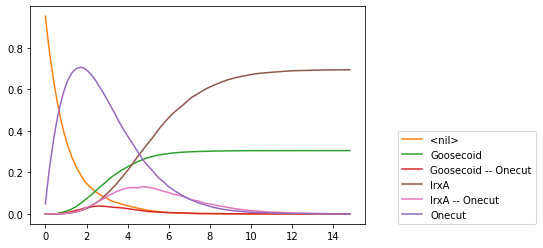

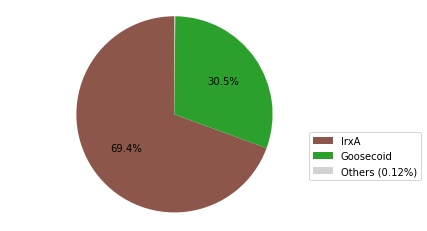

In [25]:
# Create a mutant simulation by turning OFF the Chordin_In node and rerun simulation
mutant_simulation_on = maboss.copy_and_mutate(master_simulation, ["Nodal_In_b1", "Nodal_In_b2","Lefty_In","Bmp2_4_In_b1","Admp1_In","Tolloid_In"], "ON")
mutant_simulation = maboss.copy_and_mutate(mutant_simulation_on, ["Chordin_In_b1","Chordin_In_b2","Bmp2_4_In_b2","Wnt_In","Panda"], "OFF")
mutant_res = mutant_simulation.run()
mutant_res.plot_trajectory()
plt.savefig('maboss_mut_traj.svg', dpi=300, orientation='landscape')
mutant_res.plot_piechart()
plt.savefig('maboss_mut_pie.svg', dpi=300, orientation='landscape')

**Figure 7b** : Results of the stochastic temporal simulation for the ventral territory in chordin KO condition. X axis represents time, Y axis represents the proportion of each possible states of the output nodes combinaisons.

In the chordin KO simulation however, we see a mixture of two states, one with only Goosecoid being active and the other one with only IrxA being active. Such result would be in agreement with the hypothesis that both the dorsal and ventral cascades are activated in this condition. This would suggest that the observed dorsal weak patterning from the *in-situ* experiments in the ventral territory of the chordin KO mutants results from this co-activation and mutual inhibition of the ventral and the dorsal cascade. In addition, we see that the state with the dorsal marker IrxA being active is representing a higher proportion of the simulation output states, again agreeing with the experimental results describing a weak dorsal pattern.

In order to explore further how such difference in proportion can emerge from these simulations, we modify the probability condition of the key point of the model where the divergence between the ventral and the dorsal specification happens, namely the activation of the ventral and dorsal Smads. Indeed, the activation of a smad leads at the same time to the activation of its own cascade and the to the inhibition of the other competiting smad cascade. This behavior comes from the competition for the Smad4, which recruitement is needed by both cascades.

![alt text](images/chordin_ko_htg.png "Sea urchin development")

**Figure 8** : Hierarchical Transition Graph showing the irreversible states sub-groups reached in the simulation of the chordin_KO ventral region. As before, we note that two possible stable states (i.e. ventral and dorsal) can be reached. The key point of divergence between the two stable states depends on the Smad being activated first. Once a Smad activated, the system is locked and the simulation progress irreversibly toward the corresponding cascade.

As shown in the figure above, we can pinpoint the irreversible divergence point toward either ventral or dorsal specification when one of the two smad groups is activated, as it leads to the maintainance of the competititng Smad in a "Off" state and the further activation of its own regulatory cascade.

The code below explores the temporal behavior change when the propensity to activate one cascade varies against or in favor of other.

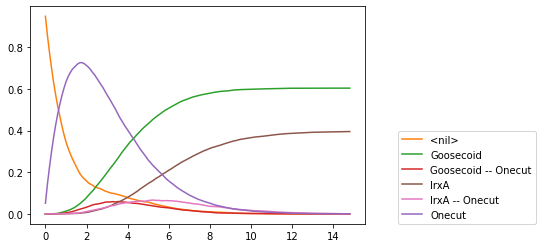

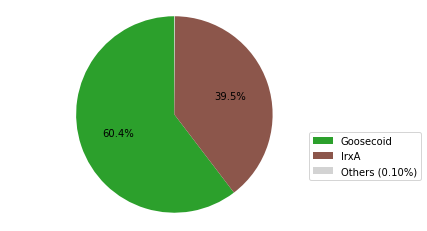

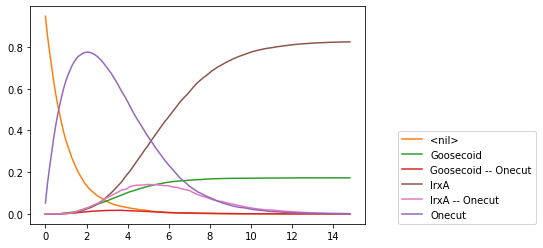

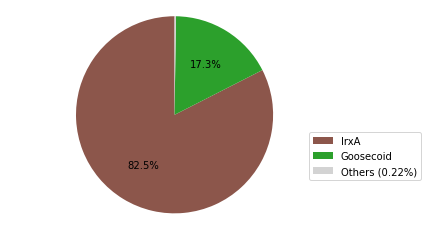

In [26]:
# Change the rate of activation and inhibtion of the chordin_KO ventral region simulation
# Increase dorsal Smad activation probability and decrease ventral Smad activation probability
mutant_simulation.network['Smad2_3_4_b1'].set_rate('0.75','0.25')
mutant_simulation.network['Smad1_4_5_8_b1'].set_rate('0.25','0.75')
mutant_res = mutant_simulation.run()
mutant_res.plot_trajectory()
plt.savefig('maboss_mutfast_traj.svg', dpi=300, orientation='landscape')
mutant_res.plot_piechart()
plt.savefig('maboss_mutfast_pie.svg', dpi=300, orientation='landscape')

# Increase ventral Smad activation probability and decrease dorsal Smad activation probability
mutant_simulation.network['Smad2_3_4_b1'].set_rate('0.25','0.75')
mutant_simulation.network['Smad1_4_5_8_b1'].set_rate('0.75','0.25')
mutant_res = mutant_simulation.run()
mutant_res.plot_trajectory()
plt.savefig('maboss_mutslow_traj.svg', dpi=300, orientation='landscape')
mutant_res.plot_piechart()
plt.savefig('maboss_mutslow_pie.svg', dpi=300, orientation='landscape')

**Figure 9** : Results of the stochastic temporal simulation for the ventral territory in chordin_KO condition with higher probability of activation for the Smad of the ventral cascade (top) or the Smad of the dorsal cascade (bottom). X axis represents time, Y axis represents the proportion of each possible states of the output nodes combinaisons.

In this simualtion, we see a change in the proportion of ventrally-defined and dorsally-defined states at the end of the simulation when we vary the dorsal and ventral Smad activation priority. In the case where we favor the activation of the dorsal Smad, the proportion of dorsally-specified output state increases above 80%, compared to the initial mutant simulation (Fig7) where the final dorsal state fraction represents approximatelty 70%.

However, the impact is even more important when we favor the activation of the ventral Smad. In this case, the major fraction of final output state is ventrally defined with 60% of the states showing expression of the ventral node Goosecoid. If such a similar experiment was performed *in vivo*, the model would predict that the ventral region of the chordin KO mutant would display a weak ventral pattern.

Finally, such results imply that in the ventral territory of the Chordin KO mutant, the key factor which leads to a dorsally-defined pattern observed in *in-situ* experiments is the temporal behavior of the system. Indeed, the stochastic simulation show that the activation of the dorsal Smad tends to be more frequent than the activation of the ventral Smad, therefore leading to a region mostly dominated by dorsal patterning with the underlying presence of a weak inhibitory action of the remaining ventral cascade.

### Conclusion

Within this notebook, we have :

- Used the bioLQM, GINsim and Pint packages to load and explore the model in a static manner.
- Performed dynamic simulation of the wild type states for each of the three ectoderm patterns.
- Performed dynamic simulation of the 8 mutants for each of the three ectoderm patterns for a total of 24 individual simulations.
- Systematically compared the simulation predictions with the expected result from *in-situ* experiment and wild-type simulations. 
- Explored the prediction results in light of the experimental evidences.
- Used MaBoss to compute stochastic temporal behavior of the mutant in conflict with the model prediction.
- Explored several rate transition levels of the Smad cascade to understand the assymetrical propensity of the two stable states observed in the simulation.